# Compute multi-model ensemble
10th, 50th and 90th percentiles output in a single file.

In [1]:
import xarray as xr
import numpy as np
import lib_david
from datetime import datetime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
#< Search parameters to filter files included in the MME
root_dir = "/g/data/ia39/ncra/drought_aridity/ai/" # replace with official delivery dir
index = "AI-atmospheric"
index_short = "AI"
gwl = ["GWL12","GWL15","GWL20","GWL30"]
data_type = "2D"
rcp = "rcp85"
mme_set = ["model","bc"]
quantiles = [0.1, 0.5, 0.9]

# file_out_name =(f"{root_dir}{index}_{data_type}_{gwl}")

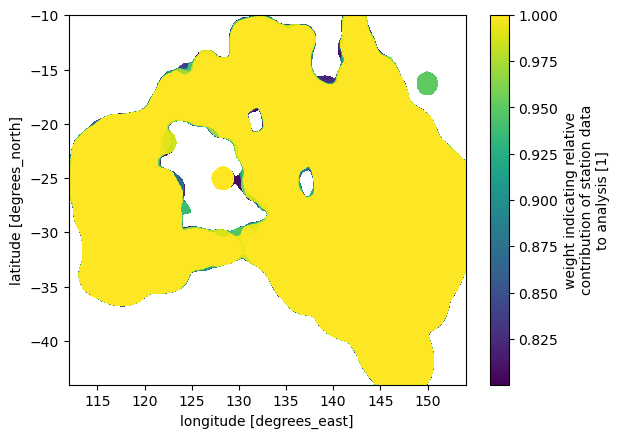

In [3]:
#< AGCD masking
mask_ds = xr.open_dataset("/g/data/mn51/users/dh4185/agcd_v1-0-2_precip_weight_r005_daily_1975_2005fraction_ge1.nc").sel(lat=slice(-44,-10),lon=slice(112,154))
q_mask = np.ma.masked_greater(mask_ds.fraction,0.8)
mask_ds.fraction.where(q_mask.mask).plot()

In [4]:
def ai_zone_change(da_gwl12, da_gwlx):
    # Define AI categories with intervals and corresponding numerical indices
    ai_categories = {
        5: (-np.inf, 0.05),  # Hyper-Arid
        4: (0.05, 0.2),      # Arid
        3: (0.2, 0.5),       # Semi-Arid
        2: (0.5, 0.65),      # Dry Sub-Humid
        1: (0.65, np.inf)    # Humid
    }
    
    # Function to assign categories based on AI values
    def assign_categories(dataarray, categories):
        categorized = xr.full_like(dataarray, np.inf, dtype=int)
        for index, (lower, upper) in categories.items():
            categorized = categorized.where(~((dataarray >= lower) & (dataarray < upper)), index)
        return categorized
    
    # Categorize AI values for both datasets
    categorized_ai_gwl12 = assign_categories(da_gwl12, ai_categories)
    categorized_ai_gwl30 = assign_categories(da_gwlx, ai_categories)
    
    # Calculate change between the two categorized datasets
    change_map = categorized_ai_gwl12 - categorized_ai_gwl30
    return change_map

### Merge individual files into one single file with model/bc dimension

In [6]:
for _gwl in gwl:
    #< Get files from root directory
    files = lib_david.get_file_paths(root_dir,".nc",include=[index,_gwl,rcp,data_type],exclude=["percentiles"])
    # for file in files:
    #     print(file)
    print(f"===========> Ensemble size: {len(files)}. Containing:")
        
    # Open files and split file strings for dimension names and add to list from which they are merged across the dimensions specified
    da_list = []
    for file in files:
        model = file.split('_')[3]
        bc = file.split('_')[-3]
        model_bc = file.split('_')[3]+"_"+file.split('_')[-3]
        # rcp = file.split('_')[4]
        # gwl = file.split('_')[-1][:-3]
    
        print('- Model: '+model_bc, 'RCP: '+rcp, 'GWL: '+_gwl) #'BC: '+bc,
        
        da = xr.open_dataset(file)['AI']
        da = da.expand_dims(dim={"model": [model_bc],"rcp": [rcp],"gwl": [_gwl]}, axis=[0,1,2]) #"bc": [bc] axis=[0,1,2,3]
        da_list.append(da)
    
    # Merge data arrays and print output
    da_all = xr.merge(da_list)
    #< attach attributes
    da_all.attrs['description'] = f'AI = Ratio of precipitation to (potential)evepotranspiration produced from National Hydrological Projections (NHP1.0) on /g/data/wj02/COMPLIANT_PUBLISHED/. Produced for ACS. '
    da_all.attrs['method']  = 'Using atmospheric-based aridity: pr/e0'
    da_all.attrs['history'] = f"Created on {now}" #cmdprov.new_log(extra_notes=[get_git_hash()])
    da_all.attrs['comment'] = f"Using data on {root_dir}"
    da_all.attrs['GWL'] = f"GWL {float(_gwl[-2:])/10}"
    da_all.attrs['RCP'] = f"RCP{float(rcp[-2:])/10}"   
    da_all.to_netcdf(f"{root_dir}AI-atmospheric-based_NHP1-AUS-5_{rcp}_bias-adjusted_2D_{_gwl}.nc")
    print("===========> Output for quantiles:") 
    print(da_all)


===========> Ensemble size: 16. Containing:
- Model: CNRM-CM5_r240x120-QME RCP: rcp85 GWL: GWL12
- Model: ACCESS1-0_CSIRO-CCAM-r3355-r240x120-ISIMIP2b RCP: rcp85 GWL: GWL12
- Model: CNRM-CM5_r240x120-MRNBC RCP: rcp85 GWL: GWL12
- Model: ACCESS1-0_r240x120-ISIMIP2b RCP: rcp85 GWL: GWL12
- Model: ACCESS1-0_r240x120-MRNBC RCP: rcp85 GWL: GWL12
- Model: CNRM-CM5_CSIRO-CCAM-r3355-r240x120-ISIMIP2b RCP: rcp85 GWL: GWL12
- Model: GFDL-ESM2M_CSIRO-CCAM-r3355-r240x120-ISIMIP2b RCP: rcp85 GWL: GWL12
- Model: GFDL-ESM2M_r240x120-QME RCP: rcp85 GWL: GWL12
- Model: MIROC5_r240x120-QME RCP: rcp85 GWL: GWL12
- Model: GFDL-ESM2M_r240x120-ISIMIP2b RCP: rcp85 GWL: GWL12
- Model: GFDL-ESM2M_r240x120-MRNBC RCP: rcp85 GWL: GWL12
- Model: ACCESS1-0_r240x120-QME RCP: rcp85 GWL: GWL12
- Model: CNRM-CM5_r240x120-ISIMIP2b RCP: rcp85 GWL: GWL12
- Model: MIROC5_r240x120-ISIMIP2b RCP: rcp85 GWL: GWL12
- Model: MIROC5_CSIRO-CCAM-r3355-r240x120-ISIMIP2b RCP: rcp85 GWL: GWL12
- Model: MIROC5_r240x120-MRNBC RCP: rcp85

### Plot and check for feasible outcome

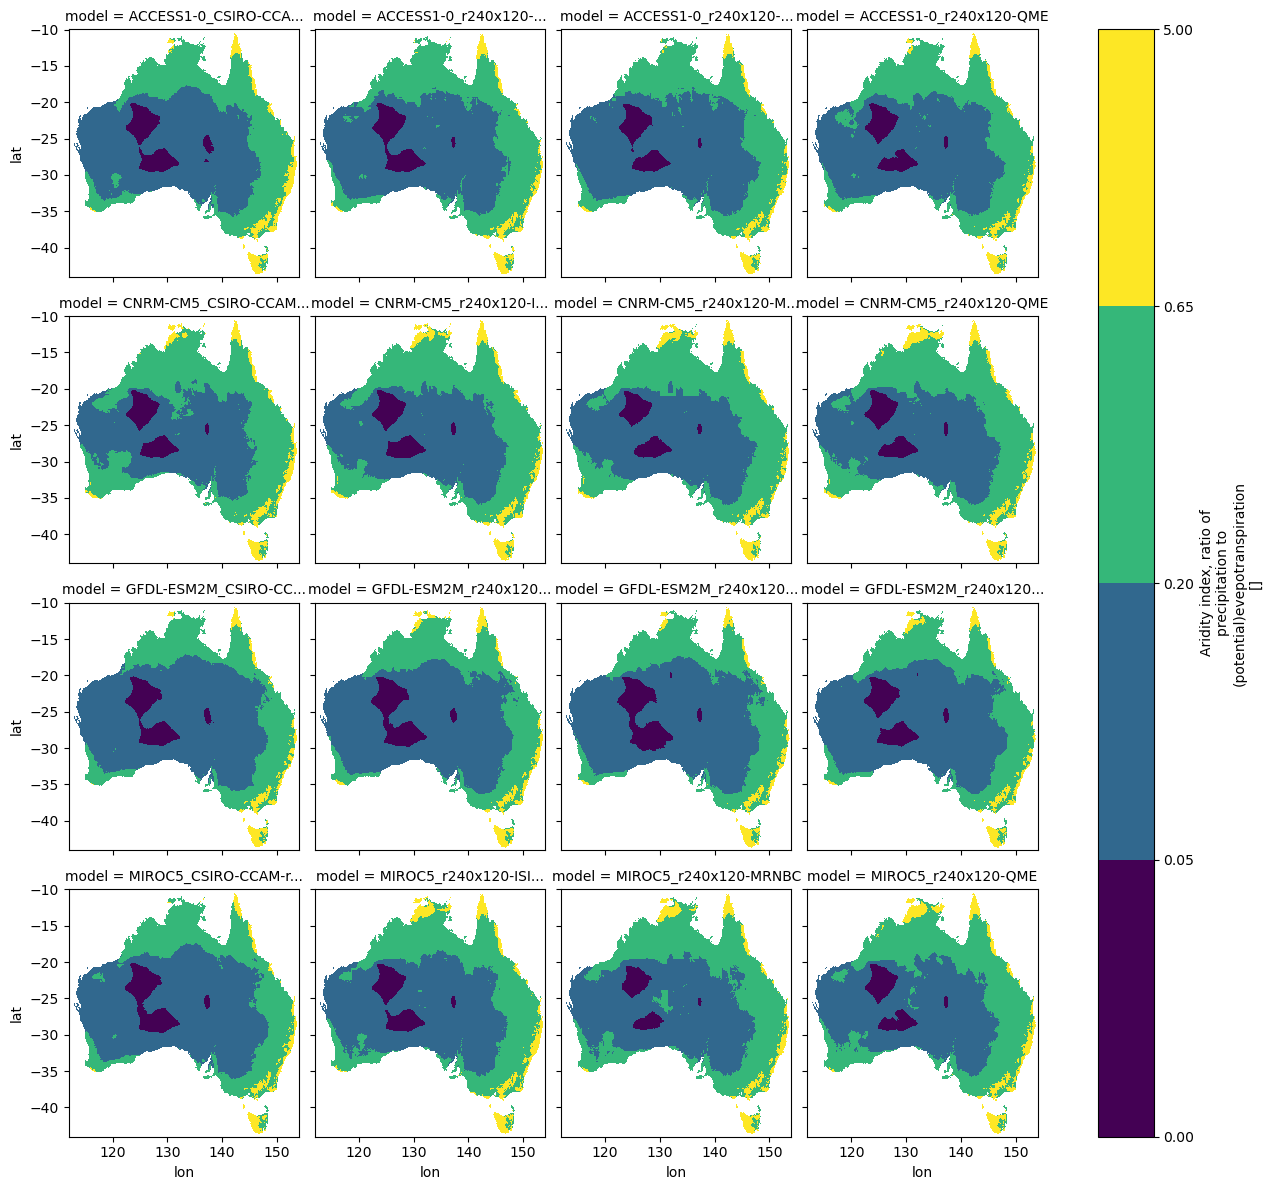

In [4]:
#< Aridity Index (AI):
quantiles_ds = xr.open_dataset(f"{root_dir}AI-atmospheric-based_NHP1-AUS-5_{rcp}_bias-adjusted_2D_GWL12.nc")#.quantile([0.1,0.5,0.9], dim = "model").squeeze()
quantiles_ds.AI.plot(col="model", col_wrap=4,levels=[0,0.05,0.2,0.65,5])

/g/data/hh5/public/apps/cms_conda/envs/analysis3-24.01/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/g/data/hh5/public/apps/cms_conda/envs/analysis3-24.01/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


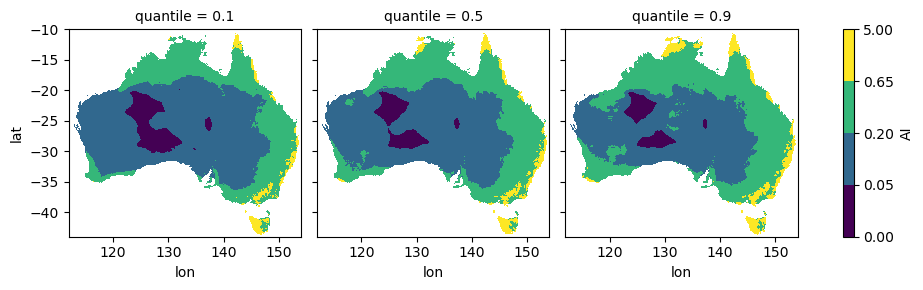

In [5]:
#< Aridity Index (AI):
quantiles_ds = xr.open_dataset(f"{root_dir}AI-atmospheric-based_NHP1-AUS-5_{rcp}_bias-adjusted_2D_GWL15.nc").quantile([0.1,0.5,0.9], dim = "model").squeeze()
quantiles_ds.AI.plot(col="quantile", levels=[0,0.05,0.2,0.65,5])

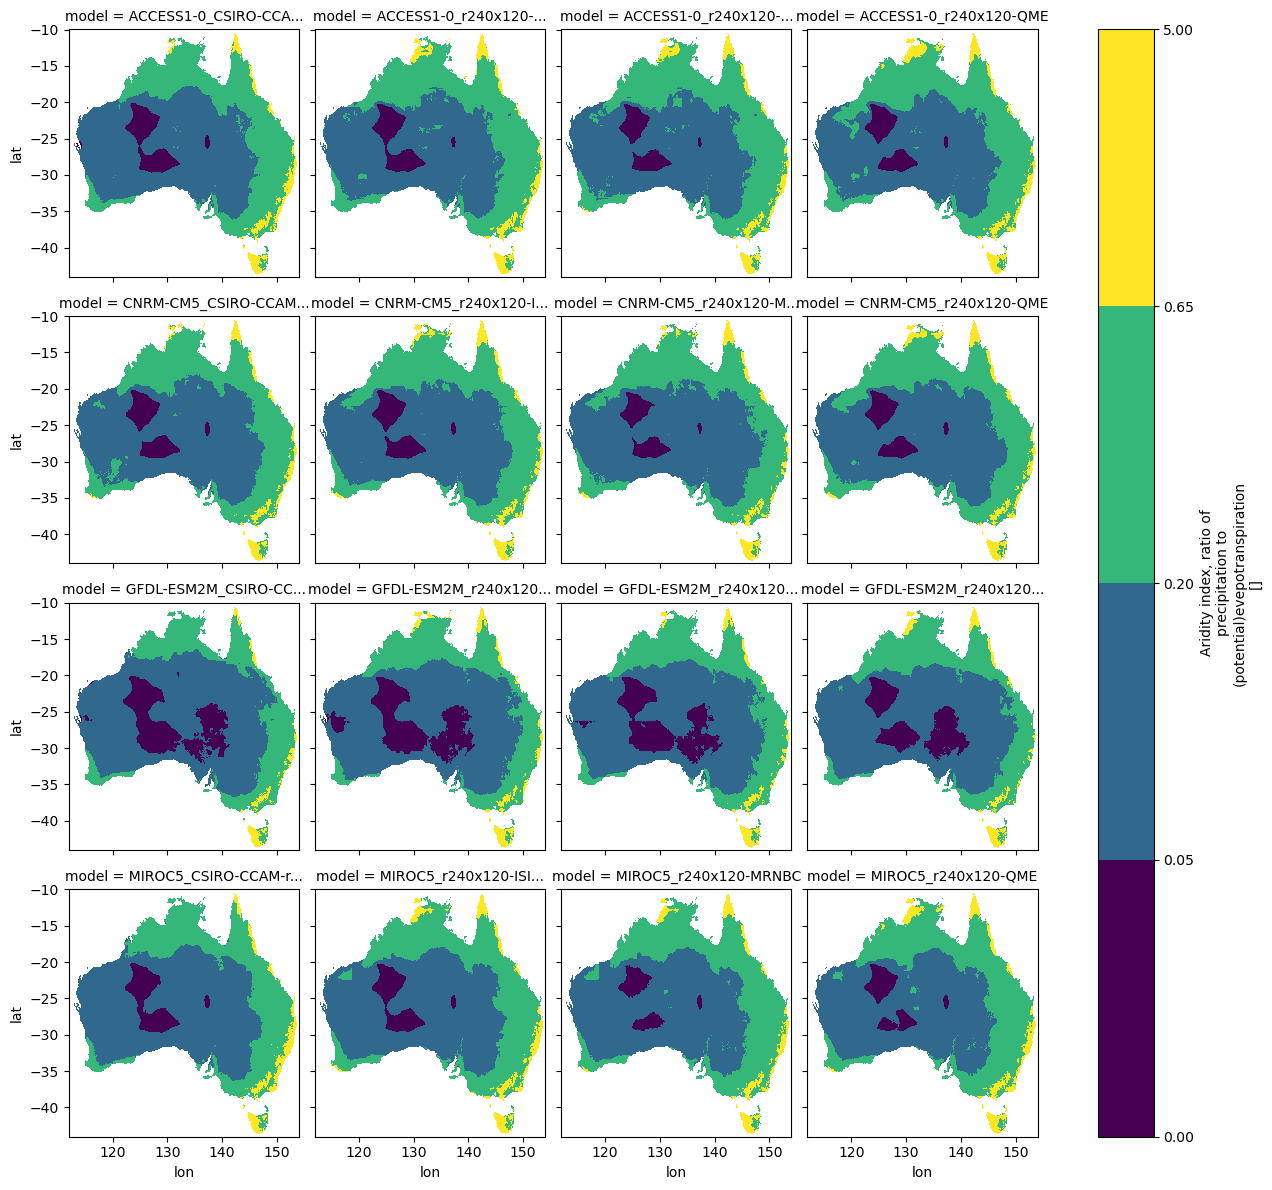

In [5]:
#< Aridity Index (AI):
quantiles_ds = xr.open_dataset(f"{root_dir}AI-atmospheric-based_NHP1-AUS-5_{rcp}_bias-adjusted_2D_GWL20.nc")#.quantile([0.1,0.5,0.9], dim = "model").squeeze()
quantiles_ds.AI.plot(col="model",col_wrap=4, levels=[0,0.05,0.2,0.65,5])

/g/data/hh5/public/apps/cms_conda/envs/analysis3-24.01/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/g/data/hh5/public/apps/cms_conda/envs/analysis3-24.01/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


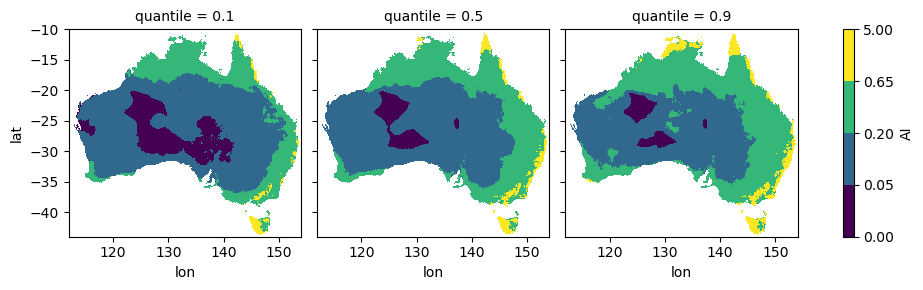

In [7]:
#< Aridity Index (AI):
quantiles_ds = xr.open_dataset(f"{root_dir}AI-atmospheric-based_NHP1-AUS-5_{rcp}_bias-adjusted_2D_GWL30.nc").quantile([0.1,0.5,0.9], dim = "model").squeeze()
quantiles_ds.AI.plot(col="quantile", levels=[0,0.05,0.2,0.65,5])

# Compute MME change

In [3]:
#< Import and open pickle file containing models and GWLs to determine matches
import pickle

# Specify the path to your .pkl file
file_path = '/g/data/mn51/users/dh4185/hazards-drought/aridity/gwl_years.pkl'

# Open the file in binary read mode
with open(file_path, 'rb') as file:
    # Load the data from the file
    models_gwl = pickle.load(file)

In [4]:
models_gwl

{'ACCESS1-0': {'rcp45': {'1.2': [2008, 2027],
   '1.5': [2022, 2041],
   '2': [2042, 2061]},
  'rcp85': {'1.2': [2010, 2029],
   '1.5': [2018, 2037],
   '2': [2031, 2050],
   '3': [2051, 2070],
   '4': [2071, 2090]}},
 'GFDL-ESM2M': {'rcp45': {'1.2': [2014, 2033], '1.5': [2037, 2056]},
  'rcp85': {'1.2': [2015, 2034],
   '1.5': [2027, 2046],
   '2': [2042, 2061],
   '3': [2073, 2092]}},
 'MIROC5': {'rcp45': {'1.2': [2019, 2038],
   '1.5': [2030, 2049],
   '2': [2063, 2082]},
  'rcp85': {'1.2': [2014, 2033],
   '1.5': [2024, 2043],
   '2': [2039, 2058],
   '3': [2063, 2082]}},
 'CNRM-CM5': {'rcp45': {'1.2': [2015, 2034],
   '1.5': [2028, 2047],
   '2': [2049, 2068]},
  'rcp85': {'1.2': [2011, 2030],
   '1.5': [2021, 2040],
   '2': [2036, 2055],
   '3': [2058, 2077],
   '4': [2078, 2097]}}}

In [7]:
#< Get files from root directory
gwls = ["GWL15","GWL20","GWL30"]
bc_methods = ["r240x120-QME","CSIRO-CCAM-r3355-r240x120-ISIMIP2b","_r240x120-ISIMIP2b","r240x120-MRNBC"]

#< iterate through GWLs 1.5, 2.0, 3.0
for _gwl in gwls:
    print(f"GWL {float(_gwl[-2:])/10}")
    #< Create an empty list to store difference to GWL12
    da_diff_list = []
    diff_pct_da_list = []
    diff_zone_da_list = []
    
    #< iterate through models
    for model in models_gwl:
        
        #< iterate through bc-methods
        for bc in bc_methods:
            model_bc = model+"_"+bc
            
            #< get GWL12 file as reference
            file_gwl12 = lib_david.get_file_paths(root_dir,".nc",include=[index,"GWL12",model,bc,rcp,data_type],exclude=["percentiles"])
            print(f"GWL1.2 file: {file_gwl12}")
            
            #< ensure there's only one possible file
            if len(file_gwl12)==1:
                da_gwl12 = xr.open_mfdataset(file_gwl12)#[index_short]
            else:
                print(f"There are {len(file_gwl12)} files in the list. Too many to continue.")
                break
        
            print(f"Getting files for {model}, {bc} and {_gwl}")
            file = lib_david.get_file_paths(root_dir,".nc",include=[index,rcp,data_type,model,bc,_gwl],exclude=["percentiles"])
            print(f"Found: {file}")
            #< ensure there's only one possible file
            if len(file)==1:
                da_gwl = xr.open_mfdataset(file)#[index_short]
            else:
                print(f"There are {len(file)} files in the list. Too many to continue.")
                break
                
            #< calculate difference: GWLx-GWL12
            diff_da = da_gwl - da_gwl12
            diff_da.attrs = da_gwl.attrs
            
            diff_da = diff_da.expand_dims(dim={"model": [model_bc]}, axis=[0])
            da_diff_list.append(diff_da)
            
            #< calculate percent change: GWLx/GWL12
            diff_pct_da = ((da_gwl - da_gwl12)/da_gwl12)*100
            diff_pct_da.attrs = da_gwl.attrs
    
            diff_pct_da = diff_pct_da.expand_dims(dim={"model": [model_bc]}, axis=[0])
            diff_pct_da_list.append(diff_pct_da)

            #< calculate zone changes
            zone_change = ai_zone_change(da_gwl12,da_gwl)
            zone_change.attrs = da_gwl.attrs

            zone_change = zone_change.expand_dims(dim={"model": [model_bc]}, axis=[0])
            diff_zone_da_list.append(zone_change)
    
    # Merge data arrays and attach attributes
    da_diff_all = xr.merge(da_diff_list).squeeze()
    da_diff_all.attrs['description'] = f'Change of AI at GWL {float(_gwl[-2:])/10} to GWL 1.2 (GWL {float(_gwl[-2:])/10} - GWL 1.2). AI = Ratio of precipitation to (potential)evepotranspiration produced from National Hydrological Projections (NHP1.0) on /g/data/wj02/COMPLIANT_PUBLISHED/. Produced for ACS. '
    da_diff_all.attrs['method']  = 'AI using atmospheric-based aridity: pr/e0'
    da_diff_all.attrs['history'] = f"Created on {now}" #cmdprov.new_log(extra_notes=[get_git_hash()])
    da_diff_all.attrs['comment'] = f"Using data on {root_dir}"
    da_diff_all.attrs['models'] = ', '.join(map(str, da_diff_all['model'].data))
    da_diff_all.attrs['GWL'] = f"GWL {float(_gwl[-2:])/10}"
    da_diff_all.attrs['RCP'] = f"RCP{float(rcp[-2:])/10}"
    da_diff_all.to_netcdf(f"{root_dir}AI-atmospheric-based_NHP1-AUS-5_{rcp}_bias-adjusted_2D_{_gwl}_abs-change-to-GWL12.nc")
    
    da_diff_pct_all = xr.merge(diff_pct_da_list).squeeze()
    da_diff_pct_all.attrs = da_diff_all.attrs
    da_diff_pct_all.attrs['description'] = f'Percent change of AI at GWL {float(_gwl[-2:])/10} to GWL 1.2 (GWL {float(_gwl[-2:])/10} / GWL 1.2). AI = Ratio of precipitation to (potential)evepotranspiration produced from National Hydrological Projections (NHP1.0) on /g/data/wj02/COMPLIANT_PUBLISHED/. Produced for ACS. '
    da_diff_pct_all.to_netcdf(f"{root_dir}AI-atmospheric-based_NHP1-AUS-5_{rcp}_bias-adjusted_2D_{_gwl}_prct-change-to-GWL12.nc")
    
    da_zone_change_all = xr.merge(diff_zone_da_list).squeeze()
    da_zone_change_all.attrs = da_diff_all.attrs
    da_zone_change_all.attrs['description'] = f"Change in aridity zone from GWL 1.2 to GWL {float(_gwl[-2:])/10}. Negative change is a transition to a more arid zone, while a positive change is a transition to a less arid zone. Based on data from National Hydrological Projections (NHP1.0) on /g/data/wj02/COMPLIANT_PUBLISHED/. Produced for ACS."
    da_zone_change_all.to_netcdf(f"{root_dir}AI-atmospheric-based_NHP1-AUS-5_{rcp}_bias-adjusted_2D_{_gwl}_zone-change-to-GWL12.nc")
    

GWL 1.5
GWL1.2 file: ['/g/data/ia39/ncra/drought_aridity/ai/AI-atmospheric-based_NHP1-AUS-5_ACCESS1-0_rcp85_r1i1p1_r240x120-QME_2D_GWL12.nc']
Getting files for ACCESS1-0, r240x120-QME and GWL15
Found: ['/g/data/ia39/ncra/drought_aridity/ai/AI-atmospheric-based_NHP1-AUS-5_ACCESS1-0_rcp85_r1i1p1_r240x120-QME_2D_GWL15.nc']
GWL1.2 file: ['/g/data/ia39/ncra/drought_aridity/ai/AI-atmospheric-based_NHP1-AUS-5_ACCESS1-0_rcp85_r1i1p1_CSIRO-CCAM-r3355-r240x120-ISIMIP2b_2D_GWL12.nc']
Getting files for ACCESS1-0, CSIRO-CCAM-r3355-r240x120-ISIMIP2b and GWL15
Found: ['/g/data/ia39/ncra/drought_aridity/ai/AI-atmospheric-based_NHP1-AUS-5_ACCESS1-0_rcp85_r1i1p1_CSIRO-CCAM-r3355-r240x120-ISIMIP2b_2D_GWL15.nc']
GWL1.2 file: ['/g/data/ia39/ncra/drought_aridity/ai/AI-atmospheric-based_NHP1-AUS-5_ACCESS1-0_rcp85_r1i1p1__r240x120-ISIMIP2b_2D_GWL12.nc']
Getting files for ACCESS1-0, _r240x120-ISIMIP2b and GWL15
Found: ['/g/data/ia39/ncra/drought_aridity/ai/AI-atmospheric-based_NHP1-AUS-5_ACCESS1-0_rcp85_r1i1p1

## Plot and check for feasible outcome

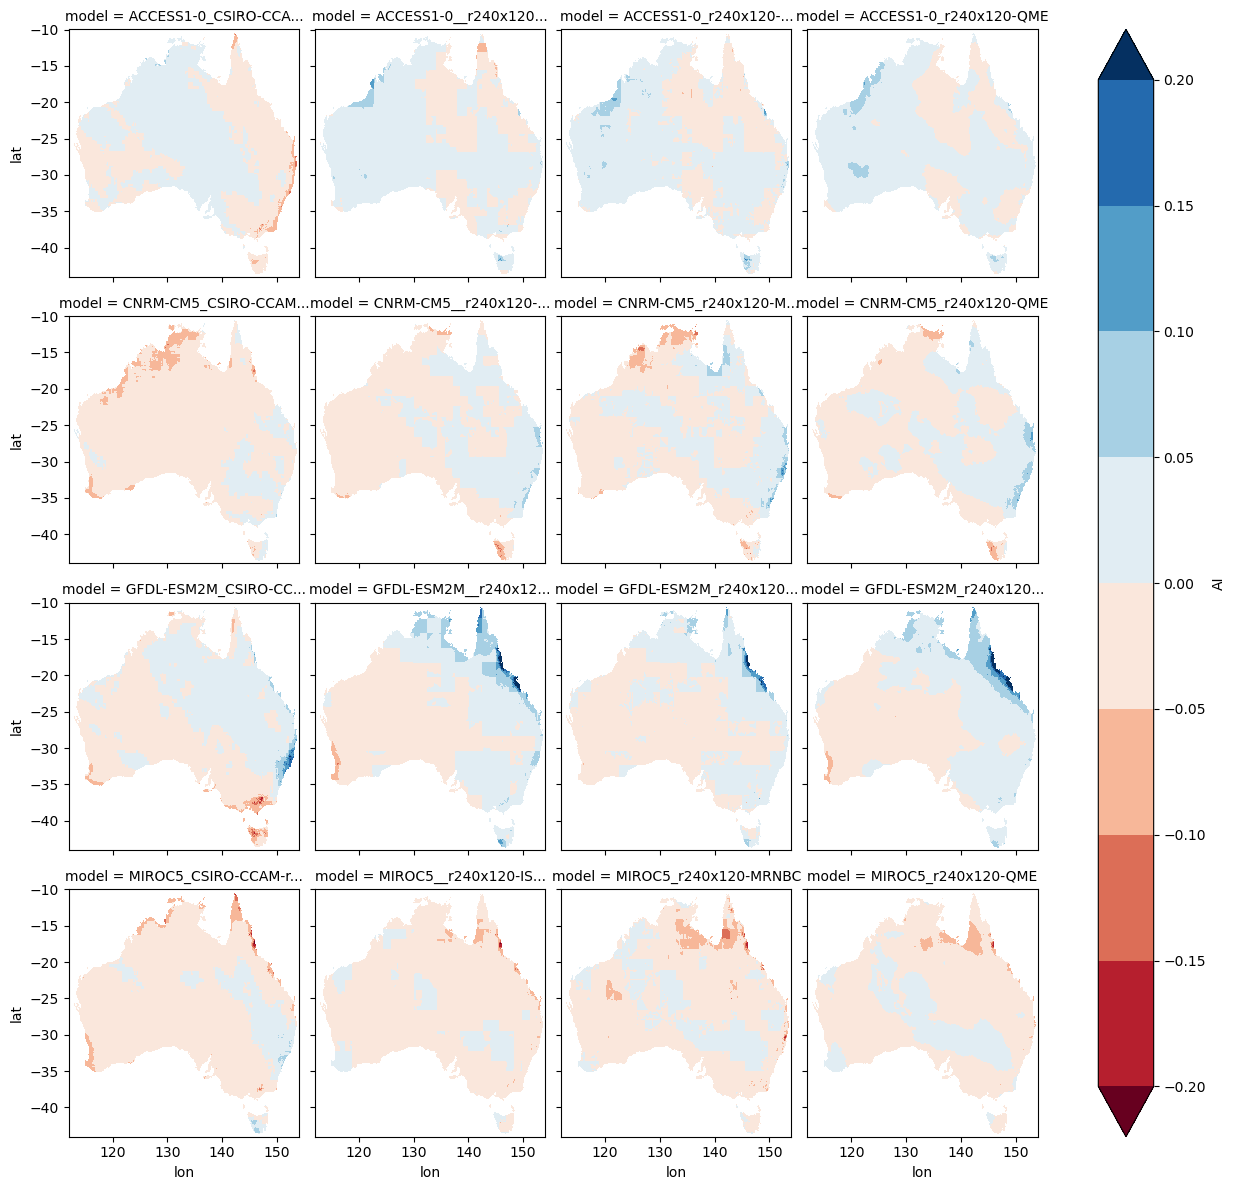

In [7]:
#< Aridity Index (AI):
quantiles_ds = xr.open_dataset(f"{root_dir}AI-atmospheric-based_NHP1-AUS-5_{rcp}_bias-adjusted_2D_GWL15_abs-change-to-GWL12.nc").where(q_mask.mask)#.quantile([0.1,0.5,0.9], dim = "model").squeeze()
quantiles_ds.AI.plot(col="model",cmap="RdBu", col_wrap=4,levels=np.arange(-0.2, 0.25, 0.05))

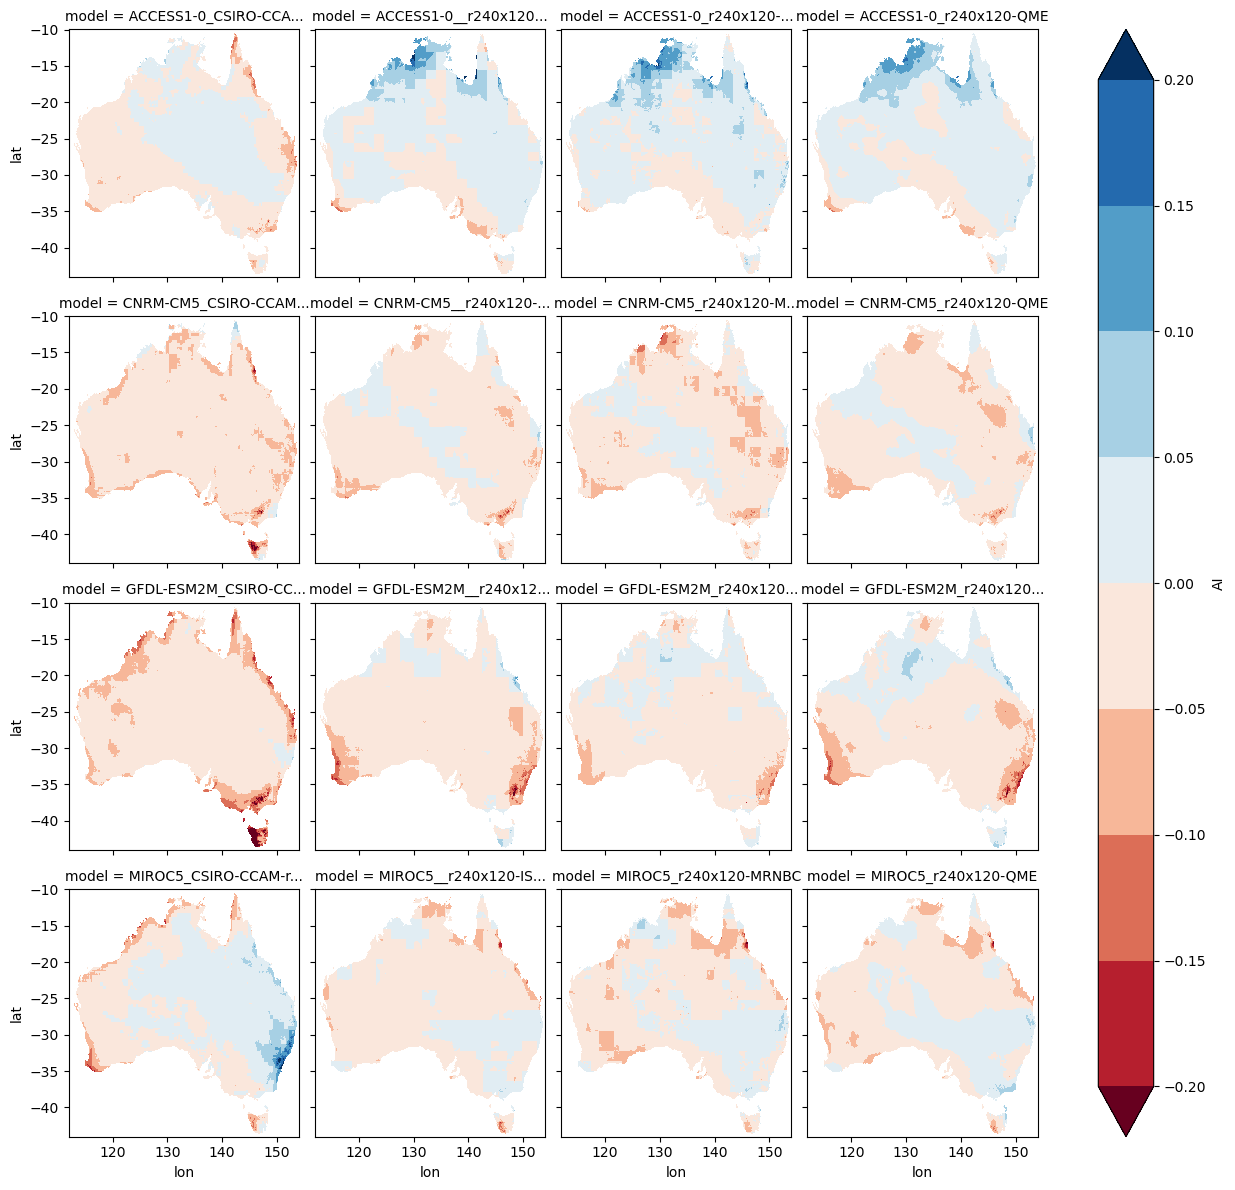

In [10]:
#< Aridity Index (AI):
quantiles_ds = xr.open_dataset(f"{root_dir}AI-atmospheric-based_NHP1-AUS-5_{rcp}_bias-adjusted_2D_GWL20_abs-change-to-GWL12.nc").where(q_mask.mask)
quantiles_ds.AI.plot(col="model",cmap="RdBu", col_wrap=4,levels=np.arange(-0.2, 0.25, 0.05))

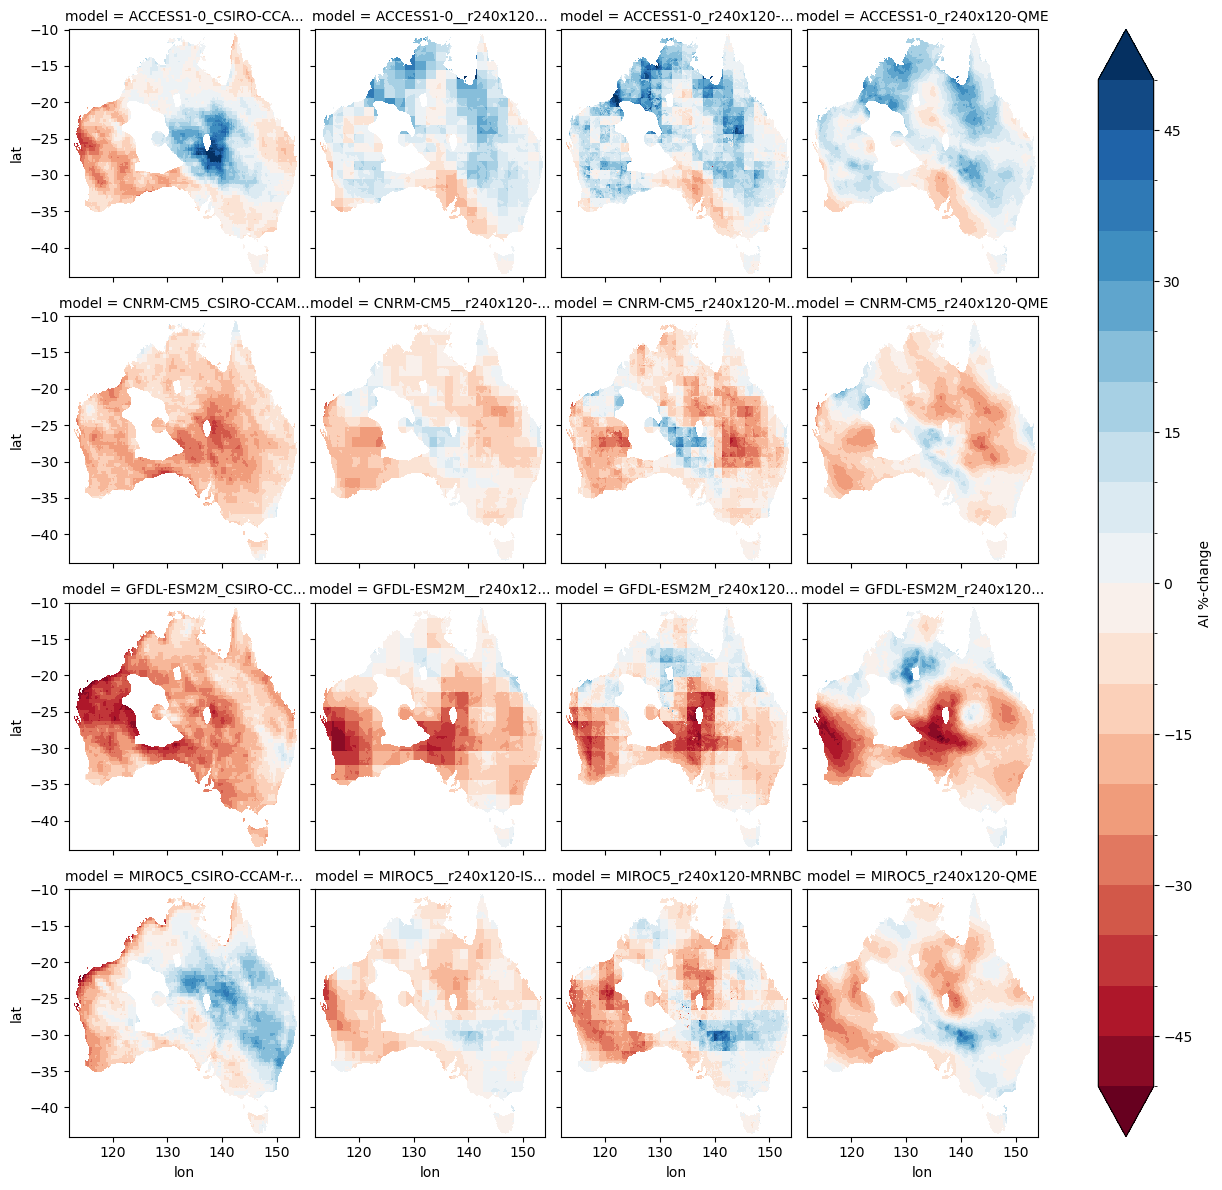

In [5]:
#< Aridity Index (AI):
quantiles_ds = xr.open_dataset(f"{root_dir}AI-atmospheric-based_NHP1-AUS-5_{rcp}_bias-adjusted_2D_GWL20_prct-change-to-GWL12.nc").where(q_mask.mask)
quantiles_ds.AI.rename("AI %-change").plot(col="model",cmap="RdBu", col_wrap=4,levels=np.arange(-50, 55, 5))

In [6]:
quantiles_ds_prct

<xarray.Dataset> Size: 37MB
Dimensions:  (model: 16, lat: 681, lon: 841)
Coordinates:
  * lon      (lon) float64 7kB 112.0 112.0 112.1 112.2 ... 153.9 153.9 154.0
  * lat      (lat) float64 5kB -44.0 -43.95 -43.9 -43.85 ... -10.1 -10.05 -10.0
  * model    (model) <U45 3kB 'ACCESS1-0_CSIRO-CCAM-r3355-r240x120-ISIMIP2b' ...
Data variables:
    AI       (model, lat, lon) float32 37MB nan nan nan nan ... nan nan nan nan
Attributes:
    description:   Ratio of precipitation to (potential)evepotranspiration pr...
    method:        Using  atmospheric-based aridity: pr/e0
    history:       Mon Aug 26 17:55:07 2024: /g/data/hh5/public/apps/minicond...
    comment:       Using data on /g/data/wj02/COMPLIANT_PUBLISHED/
    cell_methods:  time: mean

/g/data/hh5/public/apps/cms_conda/envs/analysis3-24.04/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


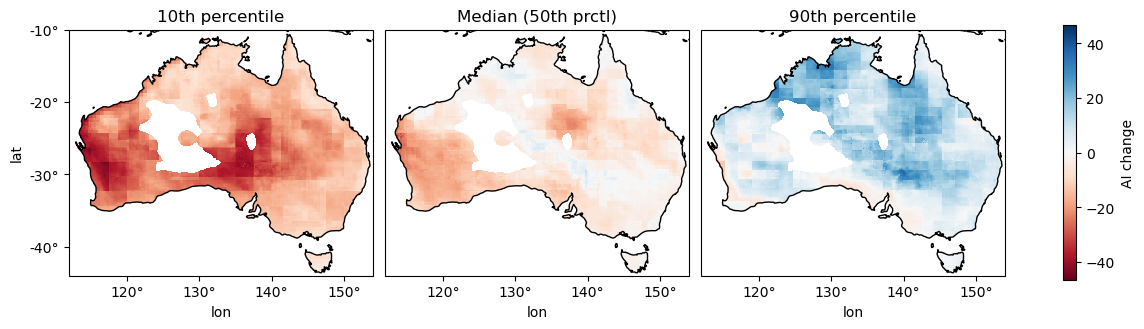

In [7]:

quantiles_ds_prct = xr.open_dataset(f"{root_dir}AI-atmospheric-based_NHP1-AUS-5_{rcp}_bias-adjusted_2D_GWL20_prct-change-to-GWL12.nc").where(q_mask.mask).quantile([0.1,0.5,0.9], dim = "model").squeeze()

# Define the plot function
def plot_quantiles(dataarray):
    titles = ["10th percentile", "Median (50th prctl)", "90th percentile"]
    p = dataarray.plot(
        col="quantile", 
        cmap="RdBu", 
        # levels=np.arange(-0.275, 0.3, 0.05),
        subplot_kws={"projection": ccrs.PlateCarree()},
        transform=ccrs.PlateCarree(),
        figsize=(12, 3),  # Adjust the figure size if necessary
        aspect=3  # Adjust aspect ratio if necessary
    )

    # Add coastlines and ticks to each subplot
    for i, ax in enumerate(p.axs.flat):
        ax.coastlines()
        ax.set_xticks(np.arange(-180, 181, 10), crs=ccrs.PlateCarree())
        
        lon_formatter = plt.FuncFormatter(lambda x, pos: f'{int(x)}°')
        lat_formatter = plt.FuncFormatter(lambda x, pos: f'{int(x)}°')
        ax.xaxis.set_major_formatter(lon_formatter)
        
        # Add latitude ticks only to the first subplot
        if i == 0:
            ax.set_yticks(np.arange(-90, 91, 10), crs=ccrs.PlateCarree())
            ax.yaxis.set_major_formatter(lat_formatter)

        # Add titles to each subplot
        ax.set_title(titles[i])

    # # Adjust the color bar length
    # p.cbar.set_aspect(20)  # Adjust the aspect ratio of the color bar
    # p.cbar.ax.tick_params(labelsize=10)  # Adjust the tick label size

    plt.show()

# Call the plot function
plot_quantiles(quantiles_ds_prct["AI"].rename("AI change"))

# quantiles_ds_prct_dict = {"10th percentile":quantiles_ds_prct.AI.sel(quantile=0.1),"Median (50th prctl)":quantiles_ds_prct.AI.sel(quantile=0.5),"90th percentile":quantiles_ds_prct.AI.sel(quantile=0.9)}
# lib_david.plot_AI(quantiles_ds_prct_dict,'change_prct','AI (P/PET) relative change (GWL2 to GWL1.2) for NHP1')#,
#        # out_dir+'AI_change_percent_current_plot_BARPA-CMIP6mean.png')

/g/data/hh5/public/apps/cms_conda/envs/analysis3-24.04/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


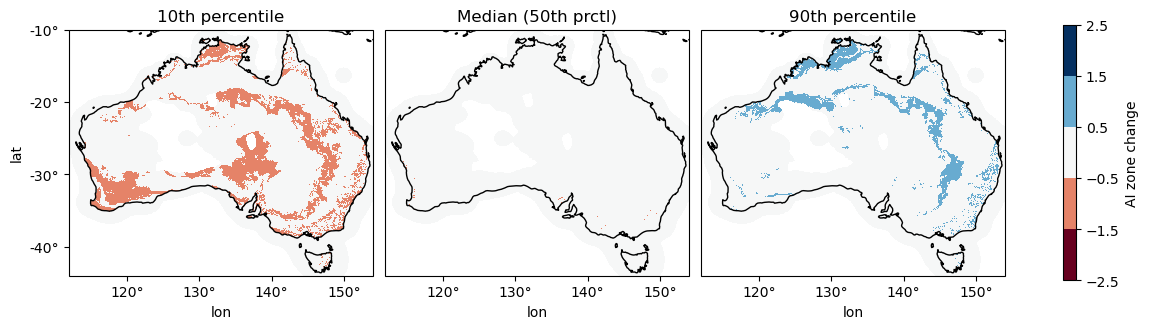

In [8]:
quantiles_ds_zone = xr.open_dataset(f"{root_dir}AI-atmospheric-based_NHP1-AUS-5_{rcp}_bias-adjusted_2D_GWL20_zone-change-to-GWL12.nc").where(q_mask.mask).quantile([0.1,0.5,0.9], dim = "model").squeeze()

# Define the plot function
def plot_quantiles(dataarray):
    titles = ["10th percentile", "Median (50th prctl)", "90th percentile"]
    p = dataarray.plot(
        col="quantile", 
        cmap="RdBu", 
        levels=np.arange(-2.5, 3.5, 1),
        subplot_kws={"projection": ccrs.PlateCarree()},
        transform=ccrs.PlateCarree(),
        figsize=(12, 3),  # Adjust the figure size if necessary
        aspect=3  # Adjust aspect ratio if necessary
    )

    # Add coastlines and ticks to each subplot
    for i, ax in enumerate(p.axs.flat):
        ax.coastlines()
        ax.set_xticks(np.arange(-180, 181, 10), crs=ccrs.PlateCarree())
        
        lon_formatter = plt.FuncFormatter(lambda x, pos: f'{int(x)}°')
        lat_formatter = plt.FuncFormatter(lambda x, pos: f'{int(x)}°')
        ax.xaxis.set_major_formatter(lon_formatter)
        
        # Add latitude ticks only to the first subplot
        if i == 0:
            ax.set_yticks(np.arange(-90, 91, 10), crs=ccrs.PlateCarree())
            ax.yaxis.set_major_formatter(lat_formatter)

        # Add titles to each subplot
        ax.set_title(titles[i])

    # # Adjust the color bar length
    # p.cbar.set_aspect(20)  # Adjust the aspect ratio of the color bar
    # p.cbar.ax.tick_params(labelsize=10)  # Adjust the tick label size

    plt.show()
plot_quantiles(quantiles_ds_zone["AI"].rename("AI zone change"))
# quantiles_ds_zone.AI.plot(col="quantile",cmap="RdBu", levels=np.arange(-2.5, 3.5, 1))